# Polynômes de chaos : application au cas de la poutre encastrée


## Résumé

Dans ce notebook, nous présentons la décomposition en chaos polynomial du cas de la poutre encastrée. Nous montrons comment obtenir les indices de Sobol' à partir d'un chaos polynomial.

In [1]:
import openturns as ot
import numpy as np
import openturns.viewer as otv
import pylab as pl
import tabulate
import math
import time

In [2]:
fastSimulation = True
if fastSimulation:
    testSampleSize = 100
    maximumPolynomialDegree = 10
else:
    testSampleSize = 1000
    maximumPolynomialDegree = 20

In [3]:
ot.__version__

'1.26'

In [4]:
class Plongeoir:
    """
    Définit le modèle physique et probabiliste d'un plongeoir.

    Cette classe encapsule la définition des variables aléatoires d'entrée
    (module de Young, charge, longueur, moment d'inertie) et la fonction
    modèle calculant la déviation verticale de la poutre.

    Examples
    --------
    >>> plongeoir = Plongeoir()
    >>> X = plongeoir.getProbabilisticModel()
    >>> g = plongeoir.getPhysicalModel()
    """
    def __init__(self):
        """
        Initialise les distributions et le modèle symbolique.
        """
        distributionE = ot.Beta(0.9, 3.5, 65.0e9, 75.0e9)
        distributionE.setDescription(["E (Pa)"])
        parametersF = ot.LogNormalMuSigma(
            300.0, 30.0, 0.0
        )  # Paramétrage par les moments
        distributionF = ot.ParametrizedDistribution(parametersF)
        distributionF.setDescription(["F (N)"])
        distributionL = ot.Uniform(2.50, 2.60)  # En mètres
        distributionL.setDescription(["L (m)"])
        distributionI = ot.Beta(2.5, 4.0, 1.3e-7, 1.7e-7)  # En m⁴
        distributionI.setDescription(["I (m⁴)"])

        self.distribution = ot.JointDistribution(
            [distributionE, distributionF, distributionL, distributionI]
        )


        def functionBeam(X):
            E, F, L, I = X
            Y = F * L**3 / (3 * E * I)
            return [Y]

        inputDimension = self.distribution.getDimension()
        outputDimension = 1
        self.model = ot.PythonFunction(inputDimension, outputDimension, functionBeam)
        self.model.setInputDescription(self.distribution.getDescription())
        self.model.setOutputDescription(["Y (m)"])

    def getProbabilisticModel(self):
        """
        Retourne la distribution conjointe des variables d'entrée.

        Returns
        -------
        distribution : ot.JointDistribution
            La distribution conjointe des variables aléatoires d'entrée.
        """
        return self.distribution

    def getPhysicalModel(self):
        """
        Retourne le modèle physique sous forme de fonction symbolique.

        Returns
        -------
        model : ot.SymbolicFunction
            La fonction calculant la déviation verticale.
        """
        return self.model

In [5]:
plongeoir = Plongeoir()
inputDistribution = plongeoir.getProbabilisticModel()
g = plongeoir.getPhysicalModel()

## Estimation des coefficients de la décomposition en polynômes du chaos

In [6]:
def computeSparseLeastSquaresFunctionalChaos(
    inputTrain,
    outputTrain,
    multivariateBasis,
    basisSize,
    inputDistribution,
    sparse=True,
):
    """
    Create a sparse polynomial chaos based on least squares.

    * Uses the enumerate rule in multivariateBasis.
    * Uses the LeastSquaresStrategy to compute the coefficients based on
      least squares.
    * For a sparse PCE, uses LeastSquaresMetaModelSelectionFactory to use 
      the LARS selection method.
      Otherwise, use PenalizedLeastSquaresAlgorithmFactory.
    * Uses FixedStrategy in order to keep all the selected coefficients.

    Parameters
    ----------
    inputTrain : ot.Sample
        The input design of experiments.
    outputTrain : ot.Sample
        The output design of experiments.
    multivariateBasis : ot.Basis
        The multivariate chaos basis.
    basisSize : int
        The size of the function basis.
    inputDistribution : ot.Distribution.
        The distribution of the input variable.
    sparse: bool
        If True, create a sparse PCE.

    Returns
    -------
    result : ot.PolynomialChaosResult
        The estimated polynomial chaos.
    """
    sampleSize = inputTrain.getSize()
    if basisSize > sampleSize:
        raise ValueError(
            f"The number of coefficients = {basisSize} is larger than the "
            f"sample size {sampleSize}"
        )
    if sparse:
        selectionAlgorithm = ot.LeastSquaresMetaModelSelectionFactory()
    else:
        selectionAlgorithm = ot.PenalizedLeastSquaresAlgorithmFactory()
    projectionStrategy = ot.LeastSquaresStrategy(
        inputTrain, outputTrain, selectionAlgorithm
    )
    adaptiveStrategy = ot.FixedStrategy(multivariateBasis, basisSize)
    chaosAlgorithm = ot.FunctionalChaosAlgorithm(
        inputTrain, outputTrain, inputDistribution, adaptiveStrategy, projectionStrategy
    )
    chaosAlgorithm.run()
    chaosResult = chaosAlgorithm.getResult()
    return chaosResult

In [7]:
def computeSparseLeastSquaresChaosFromDegree(
    inputTrain, outputTrain, totalDegree, inputDistribution, sparse=True
):
    """
    Crée un polynôme du chaos creux par moindres carrés.

    Voir computeSparseLeastSquaresFunctionalChaos() pour le 
    détail du calcul.

    Parameters
    ----------
    inputTrain : ot.Sample
        Le plan d'expérience des entrées
    outputTrain : ot.Sample
        Le plan d'expérience des sorties
    totalDegree : int
        Le degré total maximal du chaos
    inputDistribution : ot.Distribution
        La loi du vecteur aléatoire en entrée
    sparse: bool
        Si True, crée un polynôme du chaos creux avec sélection LARS

    Returns
    -------
    result : ot.FunctionalChaosResult
        La décomposition en polynômes du chaos
    """
    inputDimension = inputDistribution.getDimension()
    marginals = [inputDistribution.getMarginal(i) for i in range(inputDimension)]
    multivariateBasis = ot.OrthogonalProductPolynomialFactory(marginals)
    enumerateFunction = multivariateBasis.getEnumerateFunction()
    basisSize = enumerateFunction.getBasisSizeFromTotalDegree(totalDegree)
    result = computeSparseLeastSquaresFunctionalChaos(
        inputTrain,
        outputTrain,
        multivariateBasis,
        basisSize,
        inputDistribution,
        sparse=sparse,
    )
    return result

## Calcul du nombre de coefficients

In [8]:
def computeNumberOfCoefficientsPCE(dimension, degree):
    """
    Retourne le nombre de coefficients d'un chaos polynomial (PCE).

    Il s'agit du coefficient binomial de (dimension + degré, degré).

    Parameters
    ----------
    dimension : int
        La dimension d'entrée.
    degree : int
        Le degré du polynôme.

    Returns
    -------
    n : int
        Le nombre de coefficients.
    """
    n = math.comb(dimension + degree, degree)
    return n

In [9]:
inputDimension = g.getInputDimension()
print(f"Dimension d'entrée = {inputDimension}")
dataset = []
maximumDegree = 12
for degree in range(1, maximumDegree + 1):
    numberOfCoefficients = computeNumberOfCoefficientsPCE(inputDimension, degree)
    dataset.append([degree, numberOfCoefficients])
tabulate.tabulate(dataset, tablefmt="html", headers=["Degré", "Nbre Coeffs."])

Dimension d'entrée = 4


Degré,Nbre Coeffs.
1,5
2,15
3,35
4,70
5,126
6,210
7,330
8,495
9,715
10,1001


## Décomposition en polynômes du chaos

In [10]:
trainingSampleSize = 100  # Taille du plan d'expérience d'apprentissage
inputTrain = inputDistribution.getSample(trainingSampleSize)
outputTrain = g(inputTrain)

totalDegree = 4  # Degré polynomial
result = computeSparseLeastSquaresChaosFromDegree(
    inputTrain, outputTrain, totalDegree, inputDistribution, True
)
result

Index,Multi-index,Coeff.
0,"[0,0,0,0]",0.1706912
1,"[1,0,0,0]",-0.004303592
2,"[0,1,0,0]",0.01706906
3,"[0,0,1,0]",0.00579454
4,"[0,0,0,1]",-0.008245945
5,"[2,0,0,0]",0.000133207
6,"[1,1,0,0]",-0.0004296863
7,"[1,0,1,0]",-0.0001463693
8,"[1,0,0,1]",0.000207014
9,"[0,1,1,0]",0.0005789537


In [11]:
metamodel = result.getMetaModel()  # Récupère le métamodèle
type(metamodel)

openturns.func.Function

## Validation du métamodèle

In [12]:
testSampleSize = 1000  # Taille du plan d'expérience de validation
inputTest = inputDistribution.getSample(testSampleSize)
outputTest = g(inputTest)
val = ot.MetaModelValidation(outputTest, metamodel(inputTest))
Q2 = val.computeR2Score()[0]
Q2

0.9999998496233106

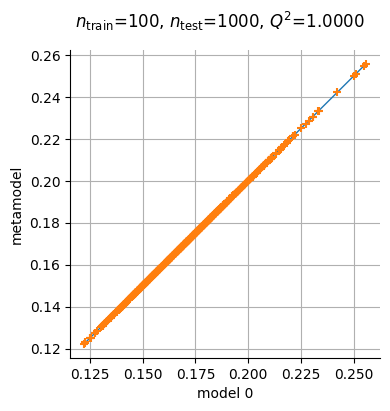

In [13]:
graph = val.drawValidation()
graph.setTitle(
    r"$n_{\text{train}}$"
    f"={trainingSampleSize}, "
    r"$n_{\text{test}}$"
    f"={testSampleSize}, "
    r"$Q^2$"
    f"={Q2:.4f}"
)
view = otv.View(
    graph,
    figure_kw={"figsize": (4.0, 4.0)},
)

## Moyenne et variance du chaos polynomial

In [14]:
chaosRV = ot.FunctionalChaosRandomVector(result)
mean = chaosRV.getMean()[0]
variance = chaosRV.getCovariance()[0, 0]
stdDev = np.sqrt(variance)
print(f"Moyenne = {mean:.4f}")
print(f"Écart-type = {stdDev:.4f}")

Moyenne = 0.1707
Écart-type = 0.0203


In [15]:
chaosRV.getSample(5)

,v0
0,0.1648841
1,0.2074614
2,0.1728438
3,0.1617192
4,0.1734367


## Analyse de sensibilité

In [16]:
chaosSI = ot.FunctionalChaosSobolIndices(result)
chaosSI

class=FunctionalChaosSobolIndices functional chaos result=class=FunctionalChaosResult derived from  metaModel=class=Function name=Unnamed implementation=class=ComposedFunction name=Unnamed description=[E (Pa),F (N),L (m),I (m⁴),Y (m)] left function=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,v0] evaluationImplementation=class=DualLinearCombinationEvaluation functions=[class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=2 values=[1.7021,2.88048],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=2 values=[-10,0.0333333],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=2 values=[0,1.73205],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=2 values=[0.649519,2.81458]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=3 values=[0.0699731,5.45791,6.71742],class=UniVariatePol

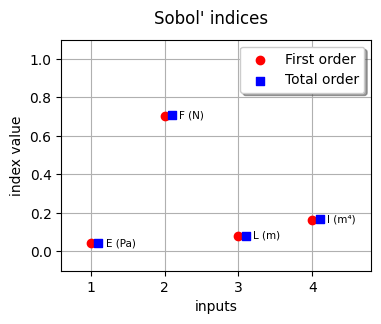

In [17]:
firstOrderIndices = [chaosSI.getSobolIndex(i) for i in range(inputDimension)]
totalOrderIndices = [chaosSI.getSobolTotalIndex(i) for i in range(inputDimension)]
inputNames = g.getInputDescription()
graph = ot.SobolIndicesAlgorithm.DrawSobolIndices(inputNames, firstOrderIndices, totalOrderIndices)
view = otv.View(
    graph,
    figure_kw={"figsize": (4.0, 3.0)},
)

## Solution de l'exercice 1 : Sensibilité à la taille du plan d'expérience d'apprentissage


Puisque nous réduisons la taille du plan d'expérience, il s'avère que le calcul d'un chaos de qualité est plus difficile. Pour rendre l'estimation des coefficients moins sensible au plan d'expériences, nous suggérons de réduire le degré du polynôme. Un degré maximum égal à 1 fonctionne souvent correctement.

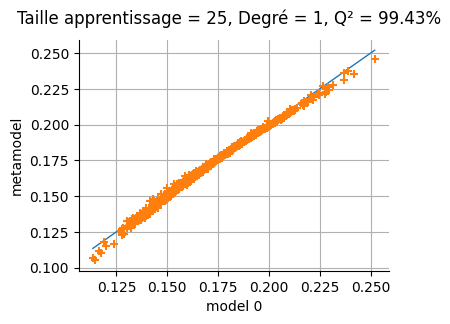

In [18]:
totalDegree = 1
trainingSampleSize = 25  # Taille du plan d'expérience
inputTrain = inputDistribution.getSample(trainingSampleSize)
outputTrain = g(inputTrain)
#
result = computeSparseLeastSquaresChaosFromDegree(
    inputTrain, outputTrain, totalDegree, inputDistribution
)
metamodel = result.getMetaModel()  # Récupère le métamodèle
#
inputTest = inputDistribution.getSample(testSampleSize)
outputTest = g(inputTest)
#
val = ot.MetaModelValidation(outputTest, metamodel(inputTest))
Q2 = val.computeR2Score()[0]
graph = val.drawValidation()
graph.setTitle(
    f"Taille apprentissage = {trainingSampleSize}, Degré = {totalDegree}, Q² = {100 * Q2:.2f}%"
)
view = otv.View(
    graph,
    figure_kw={"figsize": (4.0, 3.0)},
)

On observe que le coefficient $Q^2$ est moins élevé qu'avec le plan d'expériences précédent. 

In [19]:
def computeDegreeSensitivity(
    inputDistribution,
    g,
    trainingSampleSize,
    testSampleSize,
    multivariateBasis,
    degreeList,
    sparse=False,
    verbose=False,
):
    """
    Compute a table reflecting the sensitivity to the polynomial degree.

    The content is:
    * first column : polynomial degree
    * second column : predictivity coefficient Q2
    * third column : number of coefficients

    Parameters
    ----------
    inputDistribution : ot.Distribution
        The input distribution.
    g : ot.Function
        The model.
    trainingSampleSize : int
        The size of the training sample.
    testSampleSize : int
        The size of the test sample.
    multivariateBasis : ot.Basis
        The multivariate orthogonal polynomial basis
    degreeList : list of int
        The list of maximum total polynomial degrees
    verbose : bool
        If True, print messages.
    sparse : bool
        If True, create a sparse PCE.

    Returns
    -------
    data : numpy array((len(degreeList), 3))
        The results of the experiment.
    """
    # Generate an (input, output) pair
    inputTrain = inputDistribution.getSample(trainingSampleSize)
    outputTrain = g(inputTrain)
    #
    enumerateFunction = multivariateBasis.getEnumerateFunction()
    data = np.zeros((len(degreeList), 3))
    index = 0
    for totalDegree in degreeList:
        # 0. Check feasibility
        numberOfCoefficients = enumerateFunction.getBasisSizeFromTotalDegree(totalDegree)
        if numberOfCoefficients > trainingSampleSize:
            break
        # 1. Fit
        result = computeSparseLeastSquaresChaosFromDegree(
            inputTrain, outputTrain, totalDegree, inputDistribution, sparse=sparse
        )
        metamodel = result.getMetaModel()
        # 2. Test
        inputTest = inputDistribution.getSample(testSampleSize)
        outputTest = g(inputTest)
        val = ot.MetaModelValidation(outputTest, metamodel(inputTest))
        Q2 = val.computeR2Score()[0]
        coefficients = result.getCoefficients()
        numberOfParameters = coefficients.getSize()
        if verbose:
            print(
                f"Sample size={trainingSampleSize}, degree={totalDegree}, Q2={Q2:.4f} %"
            )
        data[index, :] = (totalDegree, Q2, numberOfParameters)
        index += 1
    return data

In [20]:
multivariateBasis = result.getOrthogonalBasis()
trainingSampleSizeList = [50, 100, 200]
degreeList = list(range(1, 6))
dataset = []
for trainingSampleSize in trainingSampleSizeList:
    print(f"Sample size = {trainingSampleSize}")
    data = computeDegreeSensitivity(
        inputDistribution,
        g,
        trainingSampleSize,
        testSampleSize,
        multivariateBasis,
        degreeList,
        verbose=False,
    )
    for row in data:
        totalDegree, Q2, numberOfParameters = row
        newData = [trainingSampleSize, totalDegree, Q2, numberOfParameters]
        dataset.append(newData)
tabulate.tabulate(dataset, tablefmt="html", headers=["N.train", "Degree", "Q2", "Nb. Coeff."])

Sample size = 50
Sample size = 100
Sample size = 200


N.train,Degree,Q2,Nb. Coeff.
50,1,0.994977,5
50,2,0.999967,15
50,3,1,35
50,0,0,0
50,0,0,0
100,1,0.996292,5
100,2,0.999986,15
100,3,1,35
100,4,1,70
100,0,0,0


On observe que le coefficient de prédictivité est sensible à la taille du plan d'expériences. Pour un plan d'expériences de taille 25, le coefficient de prédictivité peut être négatif, ce qui révèle un très mauvais métamodèle. Pour un plan d'expériences de taille 50, le coefficient de prédictivité est la plupart du temps très bon. Toutefois, augmenter le degré du polynôme au delà du degré 2 n'améliore pas beaucoup la qualité. Pour un plan d'expériences de taille 100, le coefficient de prédictivité est toujours très bon. 

On observe que pour un plan d'expériences de taille 100, augmenter le degré du polynôme au delà de 3 n'est pas très utile. En effet, le degré 3 permet d'obtenir un Q2 égal à 0.99 avec seulement 16 coefficients. Lorsqu'on augmente le degré total, la méthode de sélection de modèle n'identifie que très peu de coefficients supplémentaires et ces coefficients n'améliorent pas beaucoup la qualité.  

Pour améliorer la qualité du métamodèle, plusieurs options sont possibles.
1. La taille du plan d'expériences pourrait être augmentée. C'est une option qui nécessite d'évaluer la fonction $g$ sur un plus grand nombre de points d'entrée, ce qui peut être coûteux.
1. Le degré du polynôme pourrait être modifié. En effet, un polynôme de degré moins élevé est associé à un moins grand nombre de coefficients, qui sont plus faciles à estimer. Au contraire, il peut s'avérer que le modèle est très nonlinéaire, ce qui peut nécessiter un degré polynomial élevé.
1. On peut changer de plan d'expériences et utiliser, par exemple, une séquence à faible discrépance ou un plan LHS. C'est une option qui nécessite d'évaluer la fonction $g$ sur des nouveaux points d'entrée, ce qui peut être coûteux.
1. On pourrait changer la base polynomiale orthogonale univariée. Par exemple, il se peut que la base orthogonale associée à la loi log-normale pose une difficulté dans ce cas particulier (car la distribution log-normale n'est pas déterminée de manière unique par ses moments). On pourrait remplacer la famille de polynômes associée à la variable $F$ par la famille des polynômes de Laguerre, qui est également associée à des variables positives comme la loi log-normale.
1. On pourrait changer la règle d'énumération par une règle qui favorise les coefficients associés aux degrés élevés, sans augmenter excessivement le nombre de coefficients, comme la règle hyperbolique par exemple.

Que signifie un $Q^2$ négatif ? On sait que le coefficient $Q^2$ est ((Ross, 2004) page 377) : 
$$
Q^2\left(g\left(\boldsymbol{x}_v\right),\widetilde{g}\left(\boldsymbol{x}_v\right)\right) 
= 1 - \frac{ \sum_{j=1}^n \left( y^{(j)}_v - \widetilde{y}^{(j)}_v \right)^2}
{ \sum_{j=1}^n \left( y^{(j)}_v - \overline{y}_v \right)^2 }.
$$
où $\left\{y^{(j)}_v\right\}_{j = 1, ...,n}$ est l'échantillon de validation.

**Analyse.**

- Si $y^{(j)}_t = \widetilde{y}^{(j)}_t$ pour $j = 1, \dots, n$ (prédiction parfaite), alors $R^2 = 1$.
- Si $y^{(j)}_t = \overline{y}_v$ pour $j = 1, \dots, n$ (prédiction constante), alors $R^2 = 0$.
- Si $R^2 < 0$ : la prédiction est moins bonne qu'une prédiction constante $\overline{y}_v$.

**Références**

- Ross, S. (2004). _Introduction to probability and statistics for engineers and scientists._ 3d Edition. Elsevier. Academic Press.


La fonction suivante calcule le score Q² d'un métamodèle de chaos polynomial étant donnée une taille d'échantillon et un degré polynomial.

In [21]:
def computeQ2Score(
    inputDistribution,
    g,
    trainingSampleSize,
    testSampleSize,
    totalDegree,
):
    """
    Compute the cross-validation Q2 score of the PCE

    Parameters
    ----------
    inputDistribution : ot.Distribution
        The input distribution.
    g : ot.Function
        The model.
    trainingSampleSize : int
        The size of the training sample.
    testSampleSize : int
        The size of the test sample.
    totalDegree : int
        The total polynomial degree

    Returns
    -------
    data : numpy array((len(degreeList), 3))
        The results of the experiment.
    """
    # 1. Fit
    inputTrain = inputDistribution.getSample(trainingSampleSize)
    outputTrain = g(inputTrain)
    result = computeSparseLeastSquaresChaosFromDegree(
        inputTrain, outputTrain, totalDegree, inputDistribution, sparse=False
    )
    metamodel = result.getMetaModel()  # Récupère le métamodèle
    # 2. Test
    inputTest = inputDistribution.getSample(testSampleSize)
    outputTest = g(inputTest)
    val = ot.MetaModelValidation(outputTest, metamodel(inputTest))
    Q2 = val.computeR2Score()[0]
    Q2 = max(0.0, Q2)
    return Q2

Dans la cellule suivante, nous montrons comment augmenter itérativement la taille de l'échantillon pour voir la sensibilité du score Q² à la taille de l'échantillon. 

In [22]:
ot.RandomGenerator.SetSeed(0)  # Permet d'obtenir des résultats déterministes
numberOfRepetitions = 10
numberOfSampleSizes = 15
# Calcule la liste des distributions
inputDimension = inputDistribution.getDimension()
distributionCollection = []
for i in range(inputDimension):
    distributionCollection.append(inputDistribution.getMarginal(i))

# Crée une base multivariée
multivariateBasis = ot.OrthogonalProductPolynomialFactory(distributionCollection)
# Calcule le nombre de coefficients en fonction du degré
totalDegree = 4
enumerateFunction = multivariateBasis.getEnumerateFunction()
initialSampleSize = enumerateFunction.getBasisSizeFromTotalDegree(totalDegree)
testSampleSize = 1000
trainingSampleSizeList = np.geomspace(initialSampleSize, 20292, num=numberOfSampleSizes)
trainingSampleSizeList = [int(i) for i in trainingSampleSizeList]
print(f"Sample sizes = {trainingSampleSizeList}")

totalNumberOfExperiments = numberOfRepetitions * numberOfSampleSizes
scoreQ2Sample = []  # ot.Sample(numberOfRepetitions, numberOfSampleSizes)
maximumElapsedTime = 2.0
t1 = time.time()
for sizeIndex in range(numberOfSampleSizes):
    trainingSampleSize = trainingSampleSizeList[sizeIndex]
    print(f"Training Sample size = {trainingSampleSize}")
    scoreQ2List = []
    for repetitionIndex in range(numberOfRepetitions):
        Q2 = computeQ2Score(
            inputDistribution,
            g,
            trainingSampleSize,
            testSampleSize,
            totalDegree,
        )
        Q2 = max(0.0, Q2)
        scoreQ2List.append(Q2)
    scoreQ2Sample.append(scoreQ2List)
    t2 = time.time()
    if t2 - t1 > maximumElapsedTime:
        print(f"Maximum elapsed time reached = {maximumElapsedTime:.2f} (s)")
        break

# Transpose the data to fit the input required by Matplotlib.boxplot
scoreQ2Sample = np.array(scoreQ2Sample)
scoreQ2Sample = np.transpose(scoreQ2Sample)

Sample sizes = [70, 104, 157, 235, 353, 530, 794, 1191, 1786, 2678, 4016, 6021, 9027, 13534, 20292]
Training Sample size = 70
Training Sample size = 104
Training Sample size = 157
Training Sample size = 235
Training Sample size = 353
Training Sample size = 530
Training Sample size = 794
Maximum elapsed time reached = 2.00 (s)


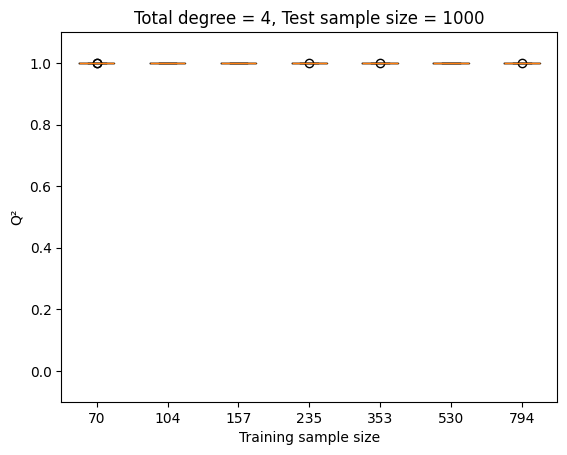

In [23]:
deltaQ2 = 0.1
numberOfSampleSizes = scoreQ2Sample.shape[1]
actualTrainingSampleSizeArray = trainingSampleSizeList[:numberOfSampleSizes]
_ = pl.boxplot(scoreQ2Sample)
pl.title(f"Total degree = {totalDegree}, Test sample size = {testSampleSize}")
_ = pl.xticks(range(1, 1 + numberOfSampleSizes), actualTrainingSampleSizeArray)
_ = pl.ylim(0.0 - deltaQ2, 1.0 + deltaQ2)
_ = pl.xlabel("Training sample size")
_ = pl.ylabel("Q²")

On observe qu'une taille d'échantillon d'apprentissage trop faible ne permet pas d'obtenir un $Q^2$ supérieur ou égal à 0.9 de manière robuste.

numberOfSampleSizes = 7


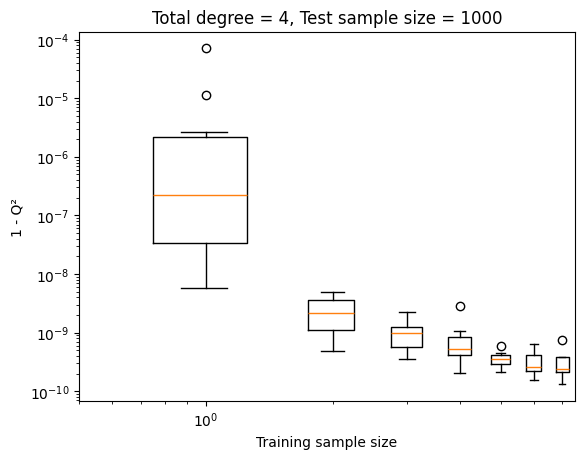

In [24]:
print(f"numberOfSampleSizes = {numberOfSampleSizes}")
fuvSample = ot.Sample(numberOfRepetitions, actualTrainingSampleSizeArray)
for sizeIndex in range(numberOfSampleSizes):
    for repetitionIndex in range(numberOfRepetitions):
        Q2 = scoreQ2Sample[repetitionIndex, sizeIndex]
        fuvSample[repetitionIndex, sizeIndex] = 1 - Q2

_ = pl.boxplot(np.array(fuvSample))
pl.title(f"Total degree = {totalDegree}, Test sample size = {testSampleSize}")
_ = pl.xticks(range(1, 1 + numberOfSampleSizes), actualTrainingSampleSizeArray)
_ = pl.yscale("log")
_ = pl.xscale("log")
_ = pl.xlabel("Training sample size")
_ = pl.ylabel("1 - Q²")

## Solution de l'exercice 2 : Sensibilité au degré total

In [25]:
# Créer des échantillons d'apprentissage et de test (afin de garder cet 
# exercice indépendant des précédents)
ot.RandomGenerator.SetSeed(0)  # Permet d'obtenir des résultats déterministes
trainingSampleSize = 1000
testSampleSize = 1000
inputTrain = inputDistribution.getSample(trainingSampleSize)
outputTrain = g(inputTrain)
inputTest = inputDistribution.getSample(testSampleSize)
outputTest = g(inputTest)

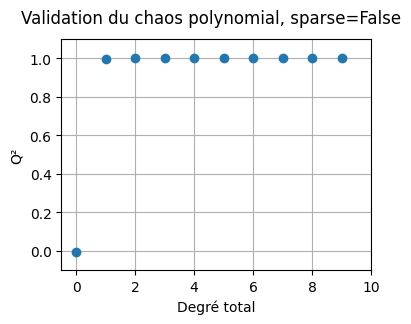

In [26]:
sparse = False  # **TODO** : ajuster ceci. Que se passe-t-il si sparse=True ?
graph = ot.Graph(f"Validation du chaos polynomial, sparse={sparse}", "Degré total", "Q²", True)
maximumDegree = 9
Q2list = []
# Boucle sur le degré
for totalDegree in range(1 + maximumDegree):
    result = computeSparseLeastSquaresChaosFromDegree(
        inputTrain, outputTrain, totalDegree, inputDistribution, sparse=sparse
    )
    metamodel = result.getMetaModel()
    val = ot.MetaModelValidation(outputTest, metamodel(inputTest))
    Q2 = val.computeR2Score()
    Q2list.append(Q2[0])
cloud = ot.Cloud(range(1 + maximumDegree), Q2list)
cloud.setPointStyle("o")
graph.add(cloud)
interval = ot.Interval([-0.5, -0.1], [1 + maximumDegree, 1.1])
graph.setBoundingBox(interval)
graph.setIntegerXTick(True)
_ = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

On observe que le degré polynomial menant à un score Q² acceptable doit être supérieur ou égal à 1. Au-delà de ce degré, le score Q² n'augmente pas beaucoup. Puisque l'on préfère un métamodèle associé à un nombre de coefficients le plus petit possible, nous pouvons choisir un polynôme de degré 1. Cette conclusion n'est valable que pour le choix particulier des lois considérées dans cet exemple.

Dans une étude, la sélection du degré optimal pourrait s'arrêter à ce point. Toutefois, la méthode de validation précédente, fondée sur l'évolution du score Q² en fonction du degré polynomial, pose au moins deux difficultés :
- le lien complexe entre le degré total et le nombre de coefficients,
- le fait que le score Q² peut être trop proche de 1 pour visualiser les différences.

**Le degré total et le nombre de coefficients**

Le lien entre le nombre de coefficients de la décomposition en polynômes de chaos et le degré total est plutôt complexe. En pratique, la taille de l'échantillon est imposée et le nombre de coefficients doit s'adapter, sans jamais dépasser le nombre d'observations disponibles. Par conséquent, il est plus facile de paramétrer la décomposition en fonction du nombre de coefficients et de la faire varier d'un nombre minimum (par exemple égal à 1) à la taille de l'échantillon (ou une fraction de celle-ci).

**Le score Q² et la fraction de variance inexpliquée 1-Q²**

Lorsque le score Q² est très proche de 1, l'inspection visuelle ne permet pas d'observer la différence entre les bons et les excellents métamodèles. En fait, le score Q² est une métrique intéressante pour éliminer les mauvais métamodèles associés à un score Q² inférieur à 0.5, mais empêche la hiérarchisation lorsque le métamodèle est de très bonne qualité. Pour les métamodèles de chaos polynomial, le score Q² n'est pas toujours une bonne métrique. La fraction de variance inexpliquée 1-Q² en échelle logarithmique peut permettre de visualiser ces différences. On pourrait également utiliser l'erreur quadratique moyenne, mais celle-ci a l'inconvénient de ne pas être normalisée.

Le code suivant exploite les deux méthodes précédentes et représente la part de variance inexpliquée en échelle logarithmique en fonction du nombre de coefficients.

In [27]:
# Créer des échantillons d'apprentissage et de test (afin de garder cet 
# exercice indépendant des précédents)
ot.RandomGenerator.SetSeed(0)  # Permet d'obtenir des résultats déterministes
trainingSampleSize = 1000
testSampleSize = 1000
inputTrain = inputDistribution.getSample(trainingSampleSize)
outputTrain = g(inputTrain)
inputTest = inputDistribution.getSample(testSampleSize)
outputTest = g(inputTest)

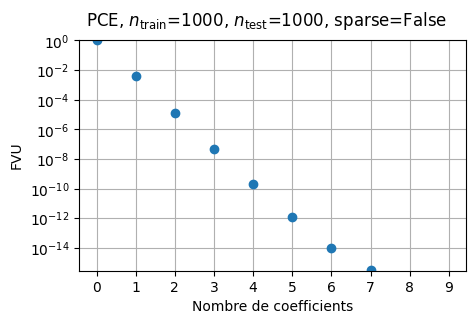

In [28]:
# Créer la base multivariée (utilise la règle d'énumération linéaire par défaut)
inputDimension = inputDistribution.getDimension()
marginals = [inputDistribution.getMarginal(i) for i in range(inputDimension)]
multivariateBasis = ot.OrthogonalProductPolynomialFactory(marginals)
#
sparse = False  # **TODO** : ajuster ceci. Que se passe-t-il si sparse=True?
# Boucle sur le nombre de coefficients
maximumDegree = 9
sampleSize = inputTrain.getSize()
fractionOfUnexplainedVarianceList = []
for totalDegree in range(1 + maximumDegree):
    result = computeSparseLeastSquaresChaosFromDegree(
        inputTrain, outputTrain, totalDegree, inputDistribution, sparse=sparse
    )
    metamodel = result.getMetaModel()
    val = ot.MetaModelValidation(outputTest, metamodel(inputTest))
    q2score = val.computeR2Score()[0]
    q2score = max(0.0, q2score)
    complementaryQ2SCore = 1.0 - q2score
    fractionOfUnexplainedVarianceList.append(complementaryQ2SCore)

# Créer le graphique
graph = ot.Graph(
    f"PCE, "
    r"$n_{\text{train}}$"
    f"={trainingSampleSize}, "
    r"$n_{\text{test}}$"
    f"={testSampleSize}, "
    f"sparse={sparse}",
    "Nombre de coefficients",
    "FVU",
    True,
)
cloud = ot.Cloud(list(range(1 + maximumDegree)), fractionOfUnexplainedVarianceList)
cloud.setPointStyle("o")
graph.add(cloud)
graph.setLegendPosition("upper left")
graph.setLegendCorner((1.0, 1.0))
graph.setIntegerXTick(True)
graph.setLogScale(ot.GraphImplementation.LOGY)
_ = otv.View(graph, figure_kw={"figsize": (5.0, 3.0)})

Dans le graphique suivant, on présente la part de variance inexpliquée en fonction du nombre de coefficients. Cela peut être utile dans les situations où on ne peut pas facilement augmenter le degré polynomial. C'est une situation qui apparaît lorsque le nombre de variables dans le modèle est important, ce qui mène à un grand nombre de coefficients. Dans ce cas, il est plus facile d'augmenter progressivement le nombre de coefficients que le degré polynomial. 

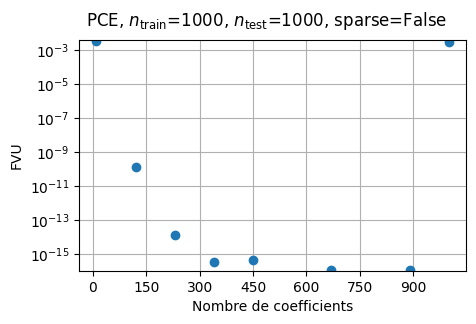

In [29]:
# Créer la base multivariée (utilise la règle d'énumération linéaire par défaut)
inputDimension = inputDistribution.getDimension()
marginals = [inputDistribution.getMarginal(i) for i in range(inputDimension)]
multivariateBasis = ot.OrthogonalProductPolynomialFactory(marginals)
#
sparse = False  # **TODO** : ajuster ceci. Que se passe-t-il si sparse=True?
# Boucle sur le nombre de coefficients
minimumBasisSize = 10
maximumBasisSize = trainingSampleSize
numberOfBasisSizes = 10
sampleSize = inputTrain.getSize()
listOfBasisSizes = np.linspace(minimumBasisSize, maximumBasisSize, numberOfBasisSizes)
listOfBasisSizes = [int(basisSize) for basisSize in listOfBasisSizes]
fractionOfUnexplainedVarianceList = []
for basisSize in listOfBasisSizes:
    result = computeSparseLeastSquaresFunctionalChaos(
        inputTrain,
        outputTrain,
        multivariateBasis,
        basisSize,
        inputDistribution,
        sparse=sparse,
    )
    metamodel = result.getMetaModel()
    val = ot.MetaModelValidation(outputTest, metamodel(inputTest))
    q2score = val.computeR2Score()[0]
    q2score = max(0.0, q2score)
    complementaryQ2SCore = 1.0 - q2score
    fractionOfUnexplainedVarianceList.append(complementaryQ2SCore)

# Créer le graphique
graph = ot.Graph(
    f"PCE, "
    r"$n_{\text{train}}$"
    f"={trainingSampleSize}, "
    r"$n_{\text{test}}$"
    f"={testSampleSize}, "
    f"sparse={sparse}",
    "Nombre de coefficients",
    "FVU",
    True,
)
cloud = ot.Cloud(listOfBasisSizes, fractionOfUnexplainedVarianceList)
cloud.setPointStyle("o")
graph.add(cloud)
graph.setLegendPosition("upper left")
graph.setLegendCorner((1.0, 1.0))
graph.setIntegerXTick(True)
graph.setLogScale(ot.GraphImplementation.LOGY)
_ = otv.View(graph, figure_kw={"figsize": (5.0, 3.0)})

On observe que la fraction de variance inexpliquée (mesurée par 1-Q²) diminue jusqu'à 400 coefficients environ, stagne puis augmente. Pour conserver une bonne prédictivité, on devrait utiliser un nombre de coefficients égal à 400 environ. Cela produit un Q² supérieur à $1 - 10^{-15}$, ce qui est très satisfaisant.


## Solution de l'exercice 3 : pourquoi éviter le calcul du R²

La cellule suivante évalue le score R².

In [30]:
metamodel = result.getMetaModel()  # Récupère le métamodèle
validation = ot.MetaModelValidation(outputTrain, metamodel(inputTrain))
R2 = validation.computeR2Score()[0]
print(f"R² = {R2:.4e}")
FVUR2 = 1 - R2
print(f"FVUR2 = {FVUR2:.4e}")

R² = 1.0000e+00
FVUR2 = 1.9984e-15


On observe que le coefficient $R^2$ est très proche de 1. Cela laisse penser que le métamodèle est d'excellente qualité, ce qui peut être vrai ou faux en fonction des situations. Dans tous les cas, ce n'est pas nécessairement une bonne métrique pour qualifier le métamodèle : on préfère en général utiliser un plan d'expérience de validation et calculer le coefficient $Q^2$. 

## Solution de l'exercice 4 : Validation croisée analytique

In [31]:
# Crée un échantillon unique (permet de rester indépendant des exercices précédents)
ot.RandomGenerator.SetSeed(0)  # Permet d'obtenir des résultats déterministes
sampleSize = 1000
inputSample = inputDistribution.getSample(sampleSize)
outputSample = g(inputSample)
# Crée la base multivariée
inputDimension = inputDistribution.getDimension()
marginals = [inputDistribution.getMarginal(i) for i in range(inputDimension)]
multivariateBasis = ot.OrthogonalProductPolynomialFactory(marginals)
# Calcul les coefficients du métamodèle
basisSize = 300
result = computeSparseLeastSquaresFunctionalChaos(
    inputSample,
    outputSample,
    multivariateBasis,
    basisSize,
    inputDistribution,
    sparse=sparse,
)
splitter = ot.LeaveOneOutSplitter(sampleSize)
validation = ot.FunctionalChaosValidation(result, splitter)
r2ScoreLOO = validation.computeR2Score()[0]
print(f"LOO R² = {r2ScoreLOO}")

LOO R² = 0.9999999999998873


## Solution de l'exercice 5 : Décroissance des coefficients

In [32]:
def plotCoefficientValueVSDegree(polynomialChaosResult):
    """
    Create a plot of total degree vs absolute value of coefficients.

    Parameters
    ----------
    polynomialChaosResult : ot.FunctionalChaosResult
        The polynomial chaos result

    Returns
    -------
    graph : ot.Graph
        A plot.
    """
    basis = polynomialChaosResult.getOrthogonalBasis()
    enumerateFunction = basis.getEnumerateFunction()
    # Get coefficients
    coefficients = polynomialChaosResult.getCoefficients()
    absCoefficient = [abs(coefficients[i][0]) for i in range(len(coefficients))]
    # Get total degree
    indices = polynomialChaosResult.getIndices()
    numberOfCoefficients = indices.getSize()
    totalDegreeList = []
    for k in range(numberOfCoefficients):
        multiIndex = enumerateFunction(indices[k])
        totalDegree = sum(multiIndex)
        totalDegreeList.append(totalDegree)
    #
    graph = ot.Graph(
        "Polynomial chaos result",
        "Total polynomial degree",
        "Coefficient absolute value",
        True,
    )
    cloud = ot.Cloud(totalDegreeList, absCoefficient)
    cloud.setPointStyle("o")
    cloud.setAlpha(0.5)
    graph.add(cloud)
    graph.setIntegerXTick(True)
    graph.setLogScale(ot.GraphImplementation.LOGY)
    return graph

Tracez les valeurs absolues des coefficients en fonction du degré polynomial total.

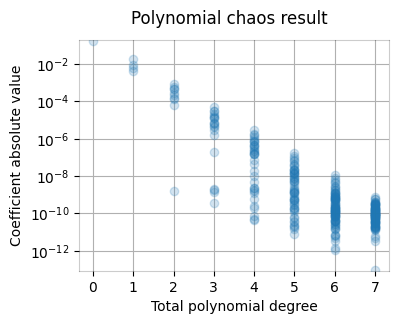

In [33]:
graph = plotCoefficientValueVSDegree(result)
view = otv.View(
    graph,
    figure_kw={"figsize": (4.0, 3.0)},
)
cloud = graph.getDrawable(0)
ax = view.getAxes()[0]
for child in ax.get_children():
    if hasattr(child, 'set_alpha'):
        child.set_alpha(0.2)

## Solution de l'exercice 6 : Énumération hyperbolique et plan d'expériences de taille 25


Dans la cellule suivante, nous créons une base de polynômes orthogonaux multivariés associés à la règle d'énumération hyperbolique.

In [34]:
inputDimension = inputDistribution.getDimension()
polynomialCollection = []
for i in range(inputDimension):
    marginal = inputDistribution.getMarginal(i)
    polynomialCollection.append(ot.StandardDistributionPolynomialFactory(marginal))

# **TODO** : ajuster ceci.
# Que se passe-t-il si on utilise q = 0.5, 0.6, 0.7, 0.8, 0.9, 1.0?
quasiNormParameter = 0.5  # Le paramètre de quasi-norme q. 
enumerateFunction = ot.HyperbolicAnisotropicEnumerateFunction(inputDimension, quasiNormParameter)
multivariateBasis = ot.OrthogonalProductPolynomialFactory(polynomialCollection, enumerateFunction)
#
totalDegree = 4
basisSize = enumerateFunction.getBasisSizeFromTotalDegree(totalDegree)
print(f"Basis size = {basisSize}")

Basis size = 23


Dans la cellule suivante, nous créons un polynôme du chaos creux sur un échantillon d'apprentissage et nous le validons sur un échantillon de test.

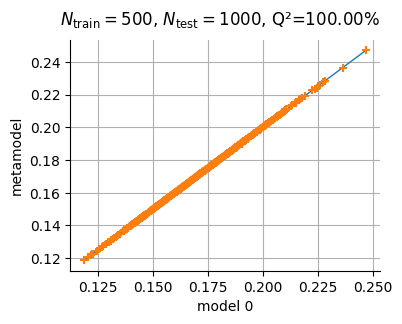

In [35]:
# 1. Créer des échantillons d'apprentissage et de test (afin de rester
# indépendant des questions précédentes)
ot.RandomGenerator.SetSeed(0)  # Permet d'obtenir des résultats déterministes
trainingSampleSize = 500
testSampleSize = 1000
inputTrain = inputDistribution.getSample(trainingSampleSize)
outputTrain = g(inputTrain)
inputTest = inputDistribution.getSample(testSampleSize)
outputTest = g(inputTest)
# 2. Apprentissage
result = computeSparseLeastSquaresFunctionalChaos(
    inputTrain,
    outputTrain,
    multivariateBasis,
    basisSize,
    inputDistribution,
    sparse=False,
)
metamodel = result.getMetaModel()
# 3. Validation
val = ot.MetaModelValidation(outputTest, metamodel(inputTest))
Q2 = val.computeR2Score()
graph = val.drawValidation()
graph.setTitle(
    r"$N_{\text{train}}=$"
    f"{outputTrain.getSize()}, "
    r"$N_{\text{test}}=$"
    f"{outputTest.getSize()}, "
    f"Q²={100 * Q2[0]:.2f}%"
)
_ = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

Le métamodèle fondé sur une règle hyperbolique n'est pas plus précis que le métamodèle fondé sur une règle linéaire. On peut en conclure que la fonction ne fait pas intervenir des interactions d'ordre élevé. Cela confirme ce que nous avions déjà observé avec l'analyse de sensibilité : les indices de Sobol' totaux sont proches des indices du premier ordre.

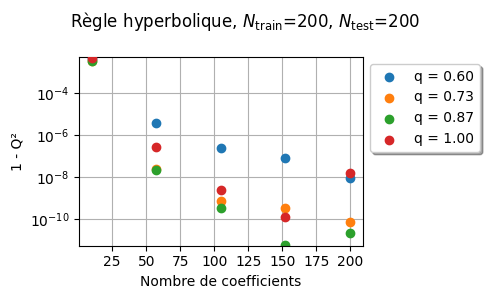

In [36]:
# Créer des échantillons d'apprentissage et de test (afin de rester
# indépendant des questions précédentes)
ot.RandomGenerator.SetSeed(0)
trainingSampleSize = 200  # Use 1000 to get a smoother plot (this takes longer)
testSampleSize = trainingSampleSize
inputTrain = inputDistribution.getSample(trainingSampleSize)
outputTrain = g(inputTrain)
inputTest = inputDistribution.getSample(testSampleSize)
outputTest = g(inputTest)

# Initialisation du graphique
graph = ot.Graph(
    f"Règle hyperbolique, "
    r"$N_{\text{train}}$"
    f"={trainingSampleSize}, "
    r"$N_{\text{test}}$"
    f"={testSampleSize}",
    f"Nombre de coefficients",
    f"1 - Q²",
    True,
)
numberOfTestedQParameters = 4  # Use 5 to get a smoother plot (this takes longer)
quasiNormParameterList = np.linspace(0.6, 1.0, numberOfTestedQParameters)
sampleSize = inputTrain.getSize()
numberOfBasisSizes = 5  # Use 15 to get a cleaner plot (this takes 20 seconds)
listOfBasisSizes = np.linspace(10, sampleSize, numberOfBasisSizes)
listOfBasisSizes = [int(basisSize) for basisSize in listOfBasisSizes]

for quasiNormParameter in quasiNormParameterList:
    Q2list = []
    for basisSize in listOfBasisSizes:
        # Utilisation de la règle d'énumération hyperbolique
        enumerateFunction = ot.HyperbolicAnisotropicEnumerateFunction(
            inputDimension, quasiNormParameter
        )
        multivariateBasis = ot.OrthogonalProductPolynomialFactory(
            polynomialCollection, enumerateFunction
        )
        result = computeSparseLeastSquaresFunctionalChaos(
            inputTrain,
            outputTrain,
            multivariateBasis,
            basisSize,
            inputDistribution,
            sparse=False,
        )
        metamodel = result.getMetaModel()
        val = ot.MetaModelValidation(outputTest, metamodel(inputTest))
        q2score = val.computeR2Score()[0]
        q2score = max(0.0, q2score)
        Q2list.append(1.0 - q2score)

    cloud = ot.Cloud(listOfBasisSizes, Q2list)
    cloud.setLegend(f"q = {quasiNormParameter:.2f}")
    cloud.setPointStyle("o")
    graph.add(cloud)

graph.setLegendPosition("upper left")
graph.setLegendCorner((1.0, 1.0))
graph.setIntegerXTick(True)
graph.setLogScale(ot.GraphImplementation.LOGY)
_ = otv.View(graph, figure_kw={"figsize": (5.0, 3.0)})

On recherche la valeur de $q$ et le nombre de coefficients tel que la part de variance inexpliquée 1-Q² soit la plus petite possible. On observe que la règle hyperbolique permet d'améliorer un peu la qualité des prédictions dans ce cas particulier. On observe que plus $q$ est proche de 1, plus la part de variance inexpliquée est proche de zéro. Lorsqu'on utilise 1000 points dans l'échantillon d'apprentissage, la valeur optimale est atteinte lorsque le nombre de coefficients est compris entre 150 et 300 et que le paramètre de quasi-norme est égal à 1. Avec 200 points, le meilleur paramètre est q=0.87, obtenu avec 150 coefficients.

## Solution de l'exercice 7 : Nombre d'observations et nombre de paramètres

In [37]:
coefficients = result.getCoefficients()
numberOfParameters = coefficients.getSize()
print(f"numberOfParameters = {numberOfParameters}")

trainingSampleSize = inputTrain.getSize()
print(f"trainingSampleSize = {trainingSampleSize}")

learningRatio = trainingSampleSize / numberOfParameters
print(f"learningRatio = {learningRatio:.3f}")

numberOfParameters = 200
trainingSampleSize = 200
learningRatio = 1.000


Si le nombre d'observations est très supérieur au nombre de paramètres, alors l'apprentissage est de qualité. Avec environ 2 observations par paramètres, le nombre d'observations est suffisant, mais il pourrait être plus grand pour assurer une meilleure qualité. 

## Solution de l'exercice 8 : Décomposition en polynômes du chaos creux

In [38]:
def printCoefficientsTable(polynomialChaosResult):
    """
    Print the coefficients of the polynomial chaos.

    This is for educational purposes only: 
    use FunctionalChaosResult._repr_html_() for actual studies, 
    or the built in pretty-print feature.

    Parameters
    ----------
    enumerateFunction : ot.EnumerateFunction
        The enumerate function.
    polynomialChaosResult : ot.PolynomialChaosResult
        The polynomial chaos result.
    """
    data = []
    basis = polynomialChaosResult.getOrthogonalBasis()
    enumerateFunction = basis.getEnumerateFunction()
    indices = polynomialChaosResult.getIndices()
    numberOfCoefficients = indices.getSize()
    for k in range(numberOfCoefficients):
        multiIndex = enumerateFunction(indices[k])
        degree = sum(multiIndex)
        c = coefficients[k][0]
        data.append((k, multiIndex, degree, c))
    return data

In [39]:
def createCantileverBeamPCE(sampleSize=200, numberOfCoefficients=50, sparse=False):
    """
    Create polynomial chaos expansion for toy cantilever beam model.

    Build a functional chaos metamodel of the cantilever beam (Plongeoir)
    problem using least squares regression on input-output sample data.
    Supports both dense and sparse polynomial chaos expansion.

    Parameters
    ----------
    sampleSize : int, optional
        Number of samples to generate from the input distribution for
        training the metamodel. Must be positive. Default is 200.
    numberOfCoefficients : int, optional
        Number of polynomial coefficients to include in the chaos
        expansion basis. Must be positive and should typically be less
        than sampleSize. Default is 50.
    sparse : bool, optional
        If True, use sparse least squares method to select most
        significant coefficients. If False, use standard least squares.
        Default is False.

    Returns
    -------
    openturns.FunctionalChaosResult
        Result object containing the trained polynomial chaos expansion
        metamodel, coefficients, and associated metadata.

    Examples
    --------
    >>> result = createCantileverBeamPCE(sampleSize=500,
    ...                                      numberOfCoefficients=100,
    ...                                      sparse=True)
    >>> metamodel = result.getMetaModel()
    >>> # Use metamodel for predictions
    >>> testInput = result.getDistribution().getSample(10)
    >>> predictions = metamodel(testInput)

    """
    plongeoir = Plongeoir()
    inputDistribution = plongeoir.getProbabilisticModel()
    g = plongeoir.getPhysicalModel()
    # Create an (input, output) sample pair
    inputSample = inputDistribution.getSample(sampleSize)
    outputSample = g(inputSample)
    # Create multivariate basis
    inputDimension = inputDistribution.getDimension()
    marginals = [inputDistribution.getMarginal(i) for i in range(inputDimension)]
    multivariateBasis = ot.OrthogonalProductPolynomialFactory(marginals)
    # Compute PCE
    result = computeSparseLeastSquaresFunctionalChaos(
        inputSample,
        outputSample,
        multivariateBasis,
        numberOfCoefficients,
        inputDistribution,
        sparse=sparse,
    )
    return result

Affiche les indices actifs, le nombre de coefficients et les coefficients.

In [40]:
ot.RandomGenerator.SetSeed(0)  # Permet d'obtenir des résultats déterministes
maximumBasisSize = 20
result = createCantileverBeamPCE(sampleSize=200, numberOfCoefficients=maximumBasisSize, sparse=True)
indices = result.getIndices()
print(f"indices={indices}")
numberOfCoefficients = indices.getSize()
print(f"numberOfCoefficients={numberOfCoefficients}")
coefficients = result.getCoefficients()
coefficients

indices=[0,1,2,3,4,5,6,7,8,10,11,12,13,14]#14
numberOfCoefficients=14


,v0
0,0.1706762
1,-0.004312483
2,0.01706665
3,0.005800559
4,-0.008266946
5,0.0001334997
6,-0.0004373353
7,-0.0001521282
8,0.0001985705
9,0.0005812096


Afficher le taux de parcimonie, calculé comme le complément du nombre de coefficients sélectionnés divisé par le nombre total de polynômes candidats de la base.

In [41]:
sparsityRatio = 1.0 - numberOfCoefficients / maximumBasisSize
print(f"{sparsityRatio * 100.0:.2f} %")

30.00 %


Le coefficient de creux est égal à 30%, ce qui est plutôt le signe d'un chaos polynomial de qualité. Comme ce ratio n'est ni trop petit ni trop grand, on peut légitimement conserver la valeur de `P` que l'on a choisie.

Affiche les multi-indices, les degrés polynomiaux et les coefficients actifs dans la décomposition creuse.

In [42]:
data = printCoefficientsTable(result)
tabulate.tabulate(
    data, tablefmt="html", headers=["Index", "Multi-Index", "Degree", "Coefficient"]
)

Index,Multi-Index,Degree,Coefficient
0,"[0,0,0,0]",0,0.170676
1,"[1,0,0,0]",1,-0.00431248
2,"[0,1,0,0]",1,0.0170667
3,"[0,0,1,0]",1,0.00580056
4,"[0,0,0,1]",1,-0.00826695
5,"[2,0,0,0]",2,0.0001335
6,"[1,1,0,0]",2,-0.000437335
7,"[1,0,1,0]",2,-0.000152128
8,"[1,0,0,1]",2,0.00019857
9,"[0,1,1,0]",2,0.00058121


**Questions, partie 2**

In [43]:
def computeBestLeastSquaresPCE(
    inputSample,
    outputSample,
    multivariateBasis,
    distribution,
    maximumDegree=20,
    sparse=False,
    verbose=False,
):
    """
    Détermine le meilleur degré polynomial par validation croisée.

    Parameters
    ----------
    inputSample : ot.Sample
        Échantillon d'entrée
    outputSample : ot.Sample
        Échantillon de sortie
    distribution : ot.Distribution
        Distribution du vecteur aléatoire X
    multivariateBasis : ot.Basis
        La base du chaos multivarié.
    maximumDegree : int, optional
        Degré maximal à explorer
    sparse: bool
        Si True, crée un chaos polynomial parcimonieux.
    verbose : bool
        Si True, affiche les messages intermédiaires.

    Returns
    -------
    bestDegree : int
        Le meilleur degré polynomial trouvé
    bestResult : ot.FunctionalChaosResult
        Meilleur PCE trouvé
    """
    bestDegree = 1
    bestMSE = np.inf
    bestResult = None

    # Créer le PCE avec le degré actuel
    enumerateFunction = multivariateBasis.getEnumerateFunction()
    sampleSize = inputSample.getSize()
    splitter = ot.LeaveOneOutSplitter(sampleSize)

    # Tester différents degrés
    for degree in range(0, maximumDegree + 1):
        if verbose:
            print(f"Essai du degré = {degree}")
        basisSize = enumerateFunction.getBasisSizeFromTotalDegree(degree)
        if basisSize >= sampleSize:
            if verbose:
                print(
                    f"Taille de l'échantillon = {sampleSize} mais taille "
                    f"de la base = {basisSize} : arrêt"
                )
            if bestResult is None:
                raise ValueError(
                    f"Impossible de trouver un meilleur chaos polynomial pour "
                    f"une taille d'échantillon de {sampleSize} "
                    f"avec un degré maximum de {maximumDegree}"
                )
            break
        result = computeSparseLeastSquaresFunctionalChaos(
            inputSample,
            outputSample,
            multivariateBasis,
            basisSize,
            distribution,
            sparse=sparse,
        )

        # Validation croisée
        validation = ot.FunctionalChaosValidation(result, splitter)
        mse = validation.computeMeanSquaredError()[0]
        if verbose:
            print(f"  EQM = {mse}")

        if mse < bestMSE:
            if verbose:
                print(f"  Meilleur chaos polynomial trouvé jusqu'ici : conservé.")
            bestMSE = mse
            bestDegree = degree
            bestResult = result

    if verbose:
        print(f"Meilleur chaos polynomial trouvé jusqu'ici : " f"degré = {bestDegree}")
    return bestDegree, bestResult

In [44]:
# Créer des échantillons d'apprentissage et de test (afin de rester 
# indépendant des questions précédentes)
ot.RandomGenerator.SetSeed(0)
sampleSize = 200 # **TODO** : ajuster ceci. Que se passe-t-il si sampleSize=500 ou 1000 ?
inputSample = inputDistribution.getSample(sampleSize)
outputSample = g(inputSample)

# Rechercher le meilleur chaos polynomial complet par moindres carrés
bestDegree, bestResult = computeBestLeastSquaresPCE(
    inputSample,
    outputSample,
    multivariateBasis,
    inputDistribution,
    maximumDegree=7,
    sparse=False,  # <- Il s'agit d'un chaos polynomial complet pour maintenir la rapidité de la procédure
    verbose=True,
)
print(f"Meilleur degré polynomial={bestDegree}")

# Une fois le meilleur degré trouvé, créer un chaos polynomial parcimonieux 
# par moindres carrés
enumerateFunction = multivariateBasis.getEnumerateFunction()
basisSize = enumerateFunction.getBasisSizeFromTotalDegree(bestDegree)
print(f"Nombre de coefficients avant sélection={basisSize}")
chaosResult = computeSparseLeastSquaresFunctionalChaos(
    inputTrain,
    outputTrain,
    multivariateBasis,
    basisSize,
    inputDistribution,
    sparse=True,  # <- Il s'agit d'un chaos polynomial parcimonieux
)
print(
    f"Nombre de coefficients après sélection="
    f"{chaosResult.getCoefficients().getSize()}"
)

Essai du degré = 0
  EQM = 0.00047914301867697513
  Meilleur chaos polynomial trouvé jusqu'ici : conservé.
Essai du degré = 1
  EQM = 2.0801188527752312e-06
  Meilleur chaos polynomial trouvé jusqu'ici : conservé.
Essai du degré = 2
  EQM = 8.49247033658693e-09
  Meilleur chaos polynomial trouvé jusqu'ici : conservé.
Essai du degré = 3
  EQM = 3.7752016686623116e-11
  Meilleur chaos polynomial trouvé jusqu'ici : conservé.
Essai du degré = 4
  EQM = 2.320322711660717e-13
  Meilleur chaos polynomial trouvé jusqu'ici : conservé.
Essai du degré = 5
  EQM = 3.2559457087421056e-15
  Meilleur chaos polynomial trouvé jusqu'ici : conservé.
Essai du degré = 6
Taille de l'échantillon = 200 mais taille de la base = 210 : arrêt
Meilleur chaos polynomial trouvé jusqu'ici : degré = 5
Meilleur degré polynomial=5
Nombre de coefficients avant sélection=126
Nombre de coefficients après sélection=80


On observe que le degré polynomial augmente jusqu'à 5 tout en rapprochant l'erreur quadratique moyenne (EQM) de zéro. On essaye ensuite d'élever encore le degré, mais cela mène à un nombre de coefficients trop grand, et l'algorithme s'arrête. Le meilleur degré trouvé est alors égal à 5. La méthode de sélection de modèle permet alors de réduire un peu le nombre de coefficients.

## Solution de l'exercice 9 : Calculer la moyenne et l'écart-type du chaos polynomial

In [ ]:
def getPCEMeanAndSD(functionalChaosResult):
    """
    Return mean and standard deviation of a polynomial chaos.

    This code is for educational purpose only:
    use FunctionalChaosRandomVector for actual studies.

    This code was adapted from
    https://github.com/openturns/openturns/blob/b5797d7e4a71c71faf86df51f26ad0d8d551ad08/lib/src/Uncertainty/Algorithm/MetaModel/FunctionalChaos/FunctionalChaosSobolIndices.cxx#L68

    See https://github.com/openturns/openturns/issues/1927

    Parameters
    ----------
    functionalChaosResult : ot.FunctionalChaosResult()
        The polynomial chaos.

    Returns
    -------
    mean : ot.Point(outputDimension)
        The expectation of Y = p(X), where p is the polynomial.
    stdDev : ot.Point(outputDimension)
        The standard deviation of Y = pc(X), where pc is the polynomial chaos,
        as the square root of the variance.
    """
    outputDimension = functionalChaosResult.getMetaModel().getOutputDimension()
    indices = functionalChaosResult.getIndices()
    coefficients = functionalChaosResult.getCoefficients()
    basisSize = indices.getSize()
    mean = ot.Point(outputDimension)
    variance = ot.Point(outputDimension)
    for i in range(outputDimension):
        for k in range(basisSize):
            # Take into account only non-zero indices as the
            # null index is the mean of the vector
            if indices[k] == 0:
                mean[i] = coefficients[k, i]
            else:
                variance[i] += coefficients[k, i] ** 2
    # Standard deviation
    stdDev = ot.Point(outputDimension)
    for i in range(outputDimension):
        stdDev[i] = np.sqrt(variance[i])
    return mean, stdDev

In [46]:
trainingSampleSize = 100  # Taille du plan d'expérience d'apprentissage
inputTrain = inputDistribution.getSample(trainingSampleSize)
outputTrain = g(inputTrain)
totalDegree = 4  # Degré polynomial
result = computeSparseLeastSquaresChaosFromDegree(
    inputTrain, outputTrain, totalDegree, inputDistribution
)

mean, stdDev = getPCEMeanAndSD(result)
print("+ Depuis getPCEMeanAndSD() :")
print(f"    Mean(PC) = {mean[0]:.4f}")
print(f"    S.D.(PC) = {stdDev[0]:.4f}")

chaosRV = ot.FunctionalChaosRandomVector(result)
mean = chaosRV.getMean()[0]
variance = chaosRV.getCovariance()[0, 0]
stdDev = np.sqrt(variance)
print("+ Depuis FunctionalChaosRandomVector:")
print(f"    Mean(PC) = {mean:.4f}")
print(f"    S.D.(PC) = {stdDev:.4f}")


+ Depuis getPCEMeanAndSD() :
    Mean(PC) = 0.1707
    S.D.(PC) = 0.0203
+ Depuis FunctionalChaosRandomVector:
    Mean(PC) = 0.1707
    S.D.(PC) = 0.0203


## Solution de l'exercice 10 : Créer un polynôme de Wiener-Hermite

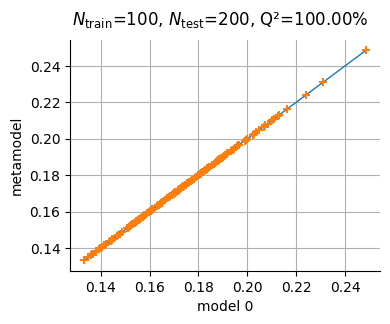

In [47]:
dimension = inputDistribution.getDimension()
hermiteFactory = ot.HermiteFactory()
enumerateFunction = ot.LinearEnumerateFunction(inputDimension)
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    [hermiteFactory] * dimension, enumerateFunction
)
trainingSampleSize = 100  # Taille du plan d'expérience d'apprentissage

inputTrain = inputDistribution.getSample(trainingSampleSize)
outputTrain = g(inputTrain)

totalDegree = 4  # Degré polynomial
result = computeSparseLeastSquaresChaosFromDegree(
    inputTrain, outputTrain, totalDegree, inputDistribution
)
metamodel = result.getMetaModel()

inputTest = inputDistribution.getSample(testSampleSize)
outputTest = g(inputTest)
#
val = ot.MetaModelValidation(outputTest, metamodel(inputTest))
Q2 = val.computeR2Score()[0]
graph = val.drawValidation()
graph.setTitle(r"$N_{\text{train}}$" f"={trainingSampleSize}, " 
               r"$N_{\text{test}}$" f"={testSampleSize}, "
               f"Q²={Q2 * 100:.2f}%")
view = otv.View(
    graph,
    figure_kw={"figsize": (4.0, 3.0)},
)

On observe que la base des polynômes d'Hermite fonctionne très bien dans ce cas particulier. 

- L'avantage de cette méthode est que la base des polynômes d'Hermite est déterminée de manière exacte par la récurrence à trois termes, dont les coefficients sont explicites. En conséquence, la base fonctionnelle créée par tensorisation des polynômes d'Hermite est numériquement proche de l'orthogonalité, même lorsque le degré polynômial est élevé, ce qui est un avantage. Puisque nous utilisons dans le cas de la poutre encastrée un degré polynomial inférieur à 5, cet avantage n'est pas très significatif. 
- Lorsqu'on utilise le schéma de Haskey pour la variable $F$, celle-ci revient à orthogonaliser la distribution log-normale. Or on sait que cette distribution n'est pas déterminée uniquement par ses moments. En conséquence, la base polynomiale générée par le procédé d'orthogonalisation de Stieljes modifié n'est pas une base complète de l'espace des fonctions $L^2$. Cela implique que, lorsqu'on augmente le degré polynomial, on est pas certain de converger vers la vraie fonction (même avec un échantillon de taille hypothétiquement infinie). L'avantage de la base de Hermite est qu'elle forme une base complète, ce qui est un avantage. 
- L'utilisation de la base de Hermite nécessite une transformation iso-probabiliste qui n'est pas nécessairement triviale en fonction des lois marginales du vecteur d'entrée du modèle physique. Dans le cas de la poutre encastrée, nous avons des lois marginales qui ne sont pas gaussiennes, ce qui entraîne une transformation non triviale pour obtenir la distribution standard gaussienne. Cette transformation peut apporter une non linéarité au modèle transformé, ce qui peut nécessiter un degré polynomial plus élevé. Ainsi, à degré polynomial égal, l'approximation par polynôme de chaos de Wiener peut être de moins bonne qualité que celui généré par le schéma de Askey, ce qui est un inconvénient.

## Exercice 11 : approximation de la distribution de la sortie


In [48]:
def kdeSample(sample, label, lineStyle):
    """
    Build kernel density estimate curve from sample data.

    Generate a probability density function (PDF) curve using kernel
    density estimation (KDE) with customizable legend and line style for
    plotting purposes.

    Parameters
    ----------
    sample : openturns.Sample
        Input data sample for which to estimate the probability density
        function. Must contain numeric values.
    label : str
        Legend label for the curve to be displayed in plots.
    lineStyle : str
        Line style specification for the curve (e.g., 'solid', 'dashed',
        'dotted', 'dashdot').

    Returns
    -------
    openturns.Drawable
        Drawable object representing the estimated PDF curve with
        specified legend and line style.

    Examples
    --------
    >>> import openturns as ot
    >>> sample = ot.Normal(0, 1).getSample(1000)
    >>> curve = kdeSample(sample, "Standard Normal", "solid")
    >>> graph = ot.Graph("KDE Plot", "X", "Density", True)
    >>> graph.add(curve)
    >>> # graph.draw("kde_plot.png")

    """
    if sample.getDimension() != 1:
        raise ValueError(
            f"The actual dimension is {sample.getDimension()}"
            "but the expected dimension is 1."
        )
    curve = ot.KernelSmoothing().build(sample).drawPDF().getDrawable(0)
    curve.setLegend(label)
    curve.setLineStyle(lineStyle)
    return curve

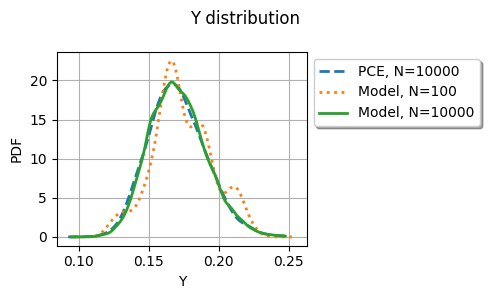

In [49]:
# 1. Create PCE
# Calcule la liste des distributions
inputDimension = inputDistribution.getDimension()
distributionCollection = []
for i in range(inputDimension):
    distributionCollection.append(inputDistribution.getMarginal(i))

multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    distributionCollection
)
trainingSampleSize = 100  # Taille du plan d'expérience d'apprentissage
inputTrain = inputDistribution.getSample(trainingSampleSize)
outputTrain = g(inputTrain)

totalDegree = 4  # Degré polynomial
result = computeSparseLeastSquaresChaosFromDegree(
    inputTrain, outputTrain, totalDegree, inputDistribution
)
metamodel = result.getMetaModel()
inputTest = inputDistribution.getSample(testSampleSize)
outputTest = g(inputTest)
#
graph = ot.Graph("Y distribution", "Y", "PDF", True)
# 2. Crée un échantillon de sortie du PCE et estime la densité
largeSampleSize = 10000
chaosRV = ot.FunctionalChaosRandomVector(result)
samplePCE = chaosRV.getSample(largeSampleSize)
distributionPCE = kdeSample(samplePCE, f"PCE, N={largeSampleSize}", "dashed")
graph.add(distributionPCE)
# 3. Compare avec la densité approchée du modèle.
# Utilise la même taille d'échantillon que celle pour estimer le PCE.
distributionModelSmall = kdeSample(
    outputTrain, f"Model, N={trainingSampleSize}", "dotted"
)
graph.add(distributionModelSmall)
# 4. Compare avec la densité estimée du modèle, avec un grand échantillon
inputTestLarge = inputDistribution.getSample(largeSampleSize)
outputTestLarge = g(inputTestLarge)
distributionModelLarge = kdeSample(
    outputTestLarge, f"Model, N={largeSampleSize}", "solid"
)
graph.add(distributionModelLarge)
# Personnalise le graphique
graph.setLegendPosition("upper left")
graph.setLegendCorner((1.0, 1.0))
view = otv.View(
    graph,
    figure_kw={"figsize": (5.0, 3.0)},
)